In [1]:
from hfnet.datasets.distillation import Distillation
from hfnet.evaluation.visualize import draw_keypoints
from utils import plot_images
import numpy as np
import cv2

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
%%time

config = {
    'load_targets': True,
#    'image_dirs': ['google_landmarks/images'],
    'image_dirs': ['bdd/night_images_vga', 'bdd/dawn_images_vga'],
    'preprocessing': {'grayscale': True},
    'targets': [
#       {'dir': 'superpoint_predictions', 'keys': ['local_descriptor_map', 'dense_scores']},
    ],
    'shuffle': True,
    'validation_size': 10,
    'truncate': [100, 100],
    'for_batching': False,
    'augmentation': {
        'photometric': {
            'enable': True,
            'primitives': [
                'random_brightness', 'random_contrast',
                'additive_gaussian_noise', 'additive_shade', 
                'motion_blur'
            ],
            'params': {
                'random_brightness': {'delta_range': [-30., 40.]},
                'random_contrast': {'strength_range': [0.3, 1.2]},
                'additive_gaussian_noise': {'stddev_range': [0, 10]},
                'additive_speckle_noise': {'prob_range': [0, 0.0035]},
                'additive_shade': {
                    'transparency_range': [-0.5, 0.5],
                    'kernel_size_range': [100, 150],
                    'prob': 0.5,
                },
                'motion_blur': {'kernel_size': [13, 21], 'prob': 0.1},
            },
        },
        'homographic': {
            'enable': False,
            'params': {
                'translation': True,
                'rotation': True,
                'scaling': True,
                'perspective': True,
                'scaling_amplitude': 0.2,
                'perspective_amplitude_x': 0.3,
                'perspective_amplitude_y': 0.3,
                'patch_ratio': 0.9,
                'max_angle': 0.3,
                'allow_artifacts': True,
            },
            'valid_border_margin': 9,
        },
    }
}
dataset = Distillation(**config)

[01/10/2019 15:45:33 INFO] Listing image files
[01/10/2019 15:45:34 INFO] Listing target files
[01/10/2019 15:45:34 INFO] Dataset size: 200


CPU times: user 756 ms, sys: 41 ms, total: 797 ms
Wall time: 798 ms


In [6]:
def draw_overlay(img, mask, color=[0, 0, 255], op=0.5, s=3):
    img = img.copy()
    if len(img.shape) == 2:
        img = img[..., np.newaxis]
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, -1)
    img[np.where(mask)] = img[np.where(mask)]*(1-op) + np.array(color)*op
    return img
def decode_scores(data, gsize=8):
    H, W, _ = data.shape
    H *= 8
    W *= 8
    _data = np.rollaxis(data, -1, 0)
    nodust = _data[:-1, :, :]
    # Reshape to get full resolution heatmap.
    Hc = int(H / gsize)
    Wc = int(W / gsize)
    nodust = nodust.transpose(1, 2, 0)
    heatmap = np.reshape(nodust, [Hc, Wc, gsize, gsize])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    return np.reshape(heatmap, [Hc*gsize, Wc*gsize])

In [ ]:
data_iter = dataset.get_training_set()
for i in range(2):
    images, names = [], []
    for _ in range(2):
        d = next(data_iter)
        img = d['image'][:, :, ::-1]
        if 'valid_mask' in d:
            img = draw_overlay(img, np.logical_not(d['valid_mask']))
        if 'keypoints' in d:
            img = draw_keypoints(img, d['keypoints'][:, ::-1])
        if 'dense_scores' in d:
            scores = decode_scores(d['dense_scores'])
            scores /= scores.max()
            overlay = cv2.applyColorMap(np.clip((255*scores), 0, 255).astype(np.uint8), cv2.COLORMAP_JET)
            img = 0.7*overlay.astype(np.float) + 0.3*img
            
        images.append(img/255)
        names.append(d['name'])
    plot_images(images, titles=names, dpi=150, cmap='gray')

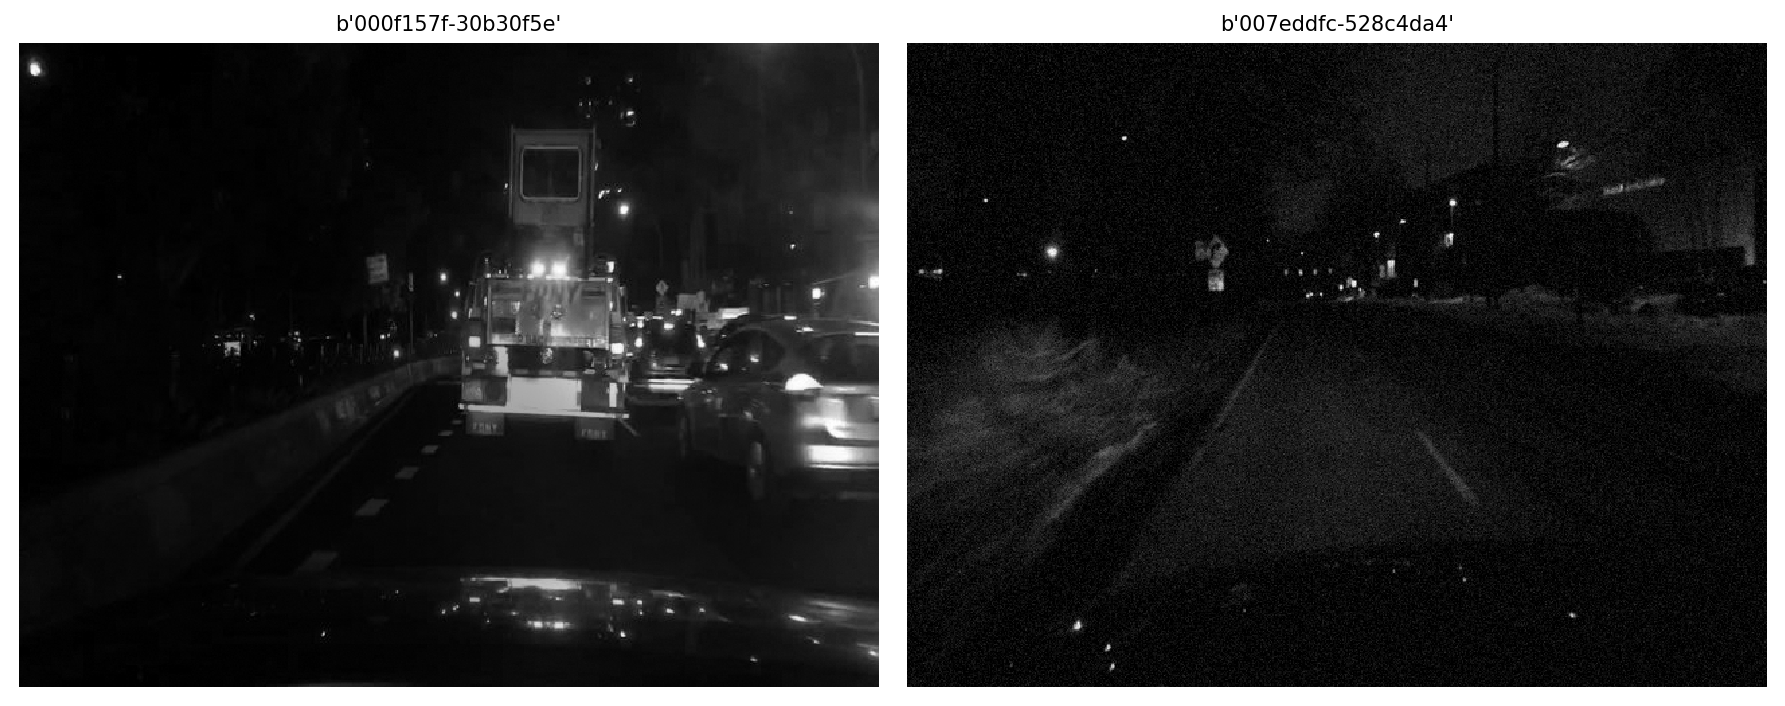

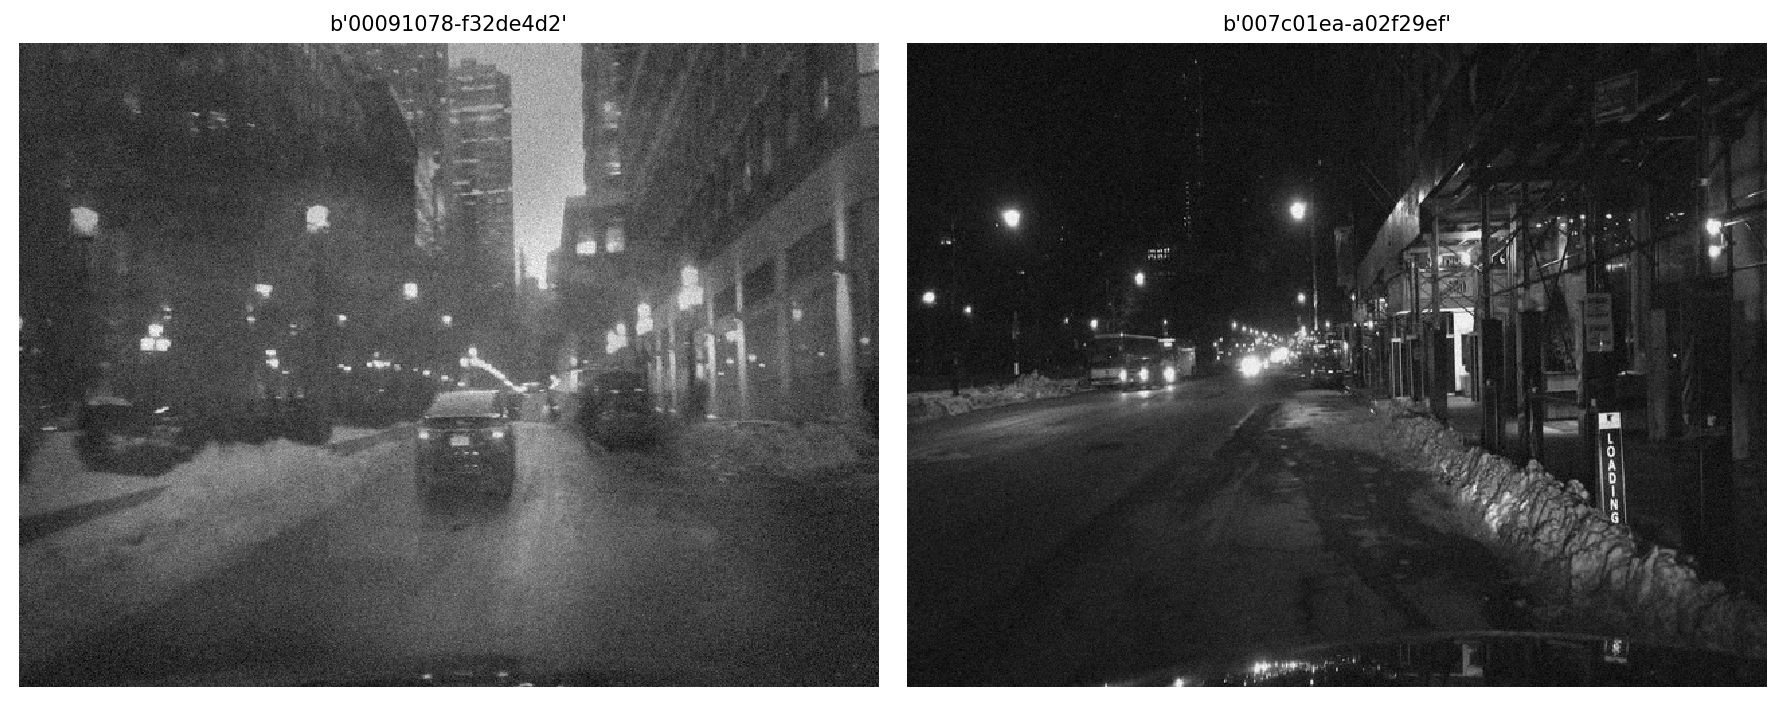

In [20]:
# BDD

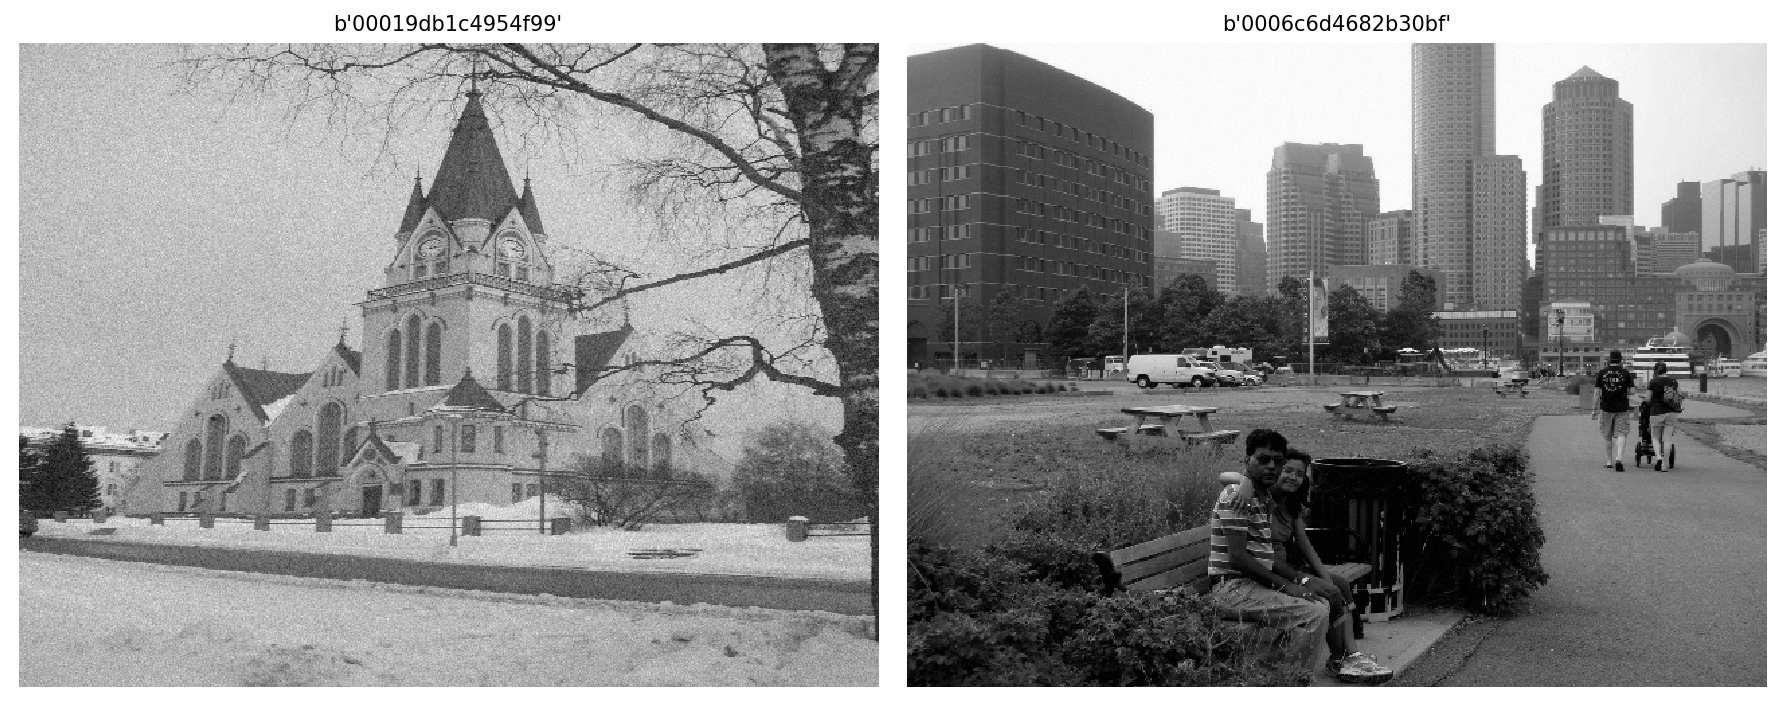

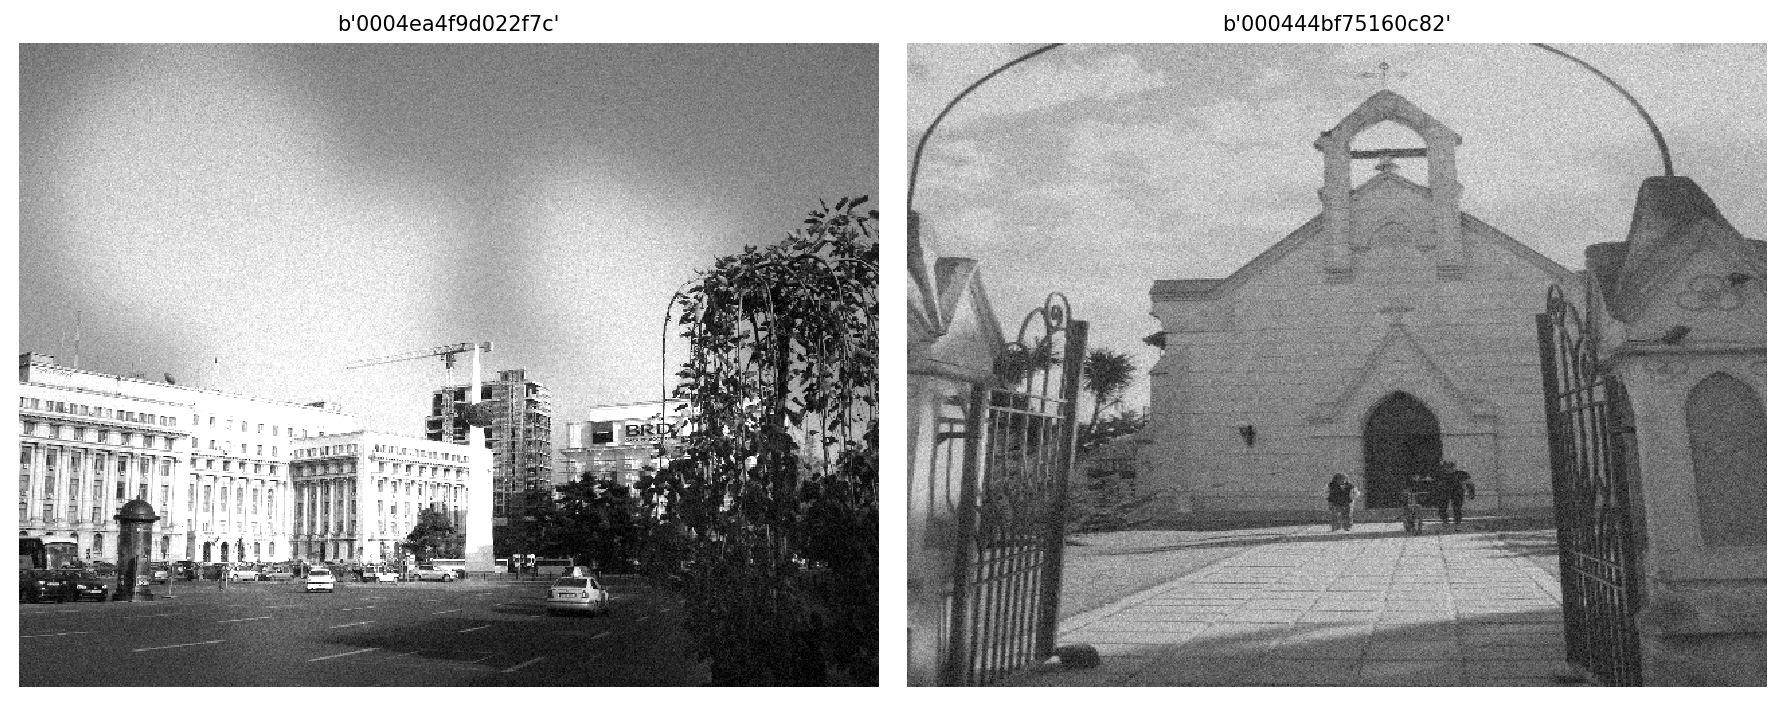

In [18]:
# GLM